### Overview
The primary goal of this competition is identification and segmentation of chest radiographic images with pneumothorax. In this kernel a U-net based approach is used, which provides end-to-end framework for image segmentation. In prior image segmentation competitions ([Airbus Ship Detection Challenge](https://www.kaggle.com/c/airbus-ship-detection/discussion) and [TGS Salt Identification Challenge](https://www.kaggle.com/c/tgs-salt-identification-challenge)), U-net based model architecture has demonstrated supperior performence, and top solutions are based on it. The current competition is similar to TGS Salt Identification Challenge in terms of identifying the correct mask based on visual inspection of images. Therefore, I have tried a technique that was extremely effective in Salt competition - [Hypercolumns](https://towardsdatascience.com/review-hypercolumn-instance-segmentation-367180495979).

As a starting point [this public kernel](https://www.kaggle.com/mnpinto/pneumothorax-fastai-u-net) is used, and the following things are added (see text below for more details):
* Hypercolumns
* Gradient accumulation
* TTA based on horizontal flip
* Noise removal (if the predicted mask contains too few pixels, it is assumed to be empty)
* Image equilibration

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, '..')

import fastai
from fastai.vision import *
from mask_functions import *
from fastai.callbacks import SaveModelCallback
import gc
from sklearn.model_selection import KFold
from PIL import Image

fastai.__version__

'1.0.55'

The original images, provided in this competition, have 1024x1024 resolution. To prevent additional overhead on image loading, the datasets composed of 128x128 and 256x256 scaled down images are prepared separately and used as an input. Check [this keknel](https://www.kaggle.com/iafoss/data-repack-and-image-statistics) for more details on image rescaling and mask generation. Also In that kernel I apply image normalization based on histograms (exposure.equalize_adapthist) that provides some improvement of image appearance as well as a small boost of the model performance. The corresponding pixel statistics are computed in the kernel.

In [2]:
sz = 256
bs = 4
n_acc = 64//bs #gradinet accumulation steps
nfolds = 2
SEED = 2019

#eliminate all predictions with a few (noise_th) pixesls
noise_th = 75.0*(sz/128.0)**2 #threshold for the number of predicted pixels
best_thr0 = 0.2 #preliminary value of the threshold for metric calculation

if sz == 256:
    stats = ([0.540,0.540,0.540],[0.264,0.264,0.264])
    TRAIN = '../data/siimacr-pneumothorax-segmentation-data-256/train'
    TEST = '../data/siimacr-pneumothorax-segmentation-data-256/test'
    MASKS = '../data/siimacr-pneumothorax-segmentation-data-256/masks'
elif sz == 128:
    stats = ([0.615,0.615,0.615],[0.291,0.291,0.291])
    TRAIN = '../data/siimacr-pneumothorax-segmentation-data-128/train'
    TEST = '../data/siimacr-pneumothorax-segmentation-data-128/test'
    MASKS = '../data/siimacr-pneumothorax-segmentation-data-128/masks'

# copy pretrained weights for resnet34 to the folder fastai will search by default
#Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
#!cp '../data/resnet34/resnet34.pth' '/tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)

### Model

The model used in this kernel is based on U-net like architecture with ResNet34 encoder. To boost the model performance, Hypercolumns are incorporated into DynamicUnet fast.ai class (see code below). The idea of Hypercolumns is schematically illustrated in the following figure. ![](https://i.ibb.co/3y7f8rj/Hypercolumns1.png)
Each upscaling block is connected to the output layer through linear resize to the original image size. So the final image is produced based on concatenation of U-net output with resized outputs of intermediate layers. These skip-connections provide a shortcut for gradient flow improving model performance and convergence speed. Since intermediate layers have many channels, their upscaling and use as an input for the final layer would introduce a significant overhead in terms the computational time and memory. Therefore, 3x3 convolutions are applied (factorization) before the resize to reduce the number of channels.
Further details on Hypercolumns can be found [here](http://home.bharathh.info/pubs/pdfs/BharathCVPR2015.pdf) and [here](https://towardsdatascience.com/review-hypercolumn-instance-segmentation-367180495979). Below the fast.ai code modified to incorporate Hypercolumns.

In [3]:
from fastai.vision.learner import create_head, cnn_config, num_features_model, create_head
from fastai.callbacks.hooks import model_sizes, hook_outputs, dummy_eval, Hook, _hook_inner
from fastai.vision.models.unet import _get_sfs_idxs, UnetBlock

class Hcolumns(nn.Module):
    def __init__(self, hooks:Collection[Hook], nc:Collection[int]=None):
        super(Hcolumns,self).__init__()
        self.hooks = hooks
        self.n = len(self.hooks)
        self.factorization = None 
        if nc is not None:
            self.factorization = nn.ModuleList()
            for i in range(self.n):
                self.factorization.append(nn.Sequential(
                    conv2d(nc[i],nc[-1],3,padding=1,bias=True),
                    conv2d(nc[-1],nc[-1],3,padding=1,bias=True)))
                #self.factorization.append(conv2d(nc[i],nc[-1],3,padding=1,bias=True))
        
    def forward(self, x:Tensor):
        n = len(self.hooks)
        out = [F.interpolate(self.hooks[i].stored if self.factorization is None
            else self.factorization[i](self.hooks[i].stored), scale_factor=2**(self.n-i),
            mode='bilinear',align_corners=False) for i in range(self.n)] + [x]
        return torch.cat(out, dim=1)

class DynamicUnet_Hcolumns(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder:nn.Module, n_classes:int, blur:bool=False, blur_final=True, 
                 self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_layer(ni, ni*2, **kwargs),
                                    conv_layer(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        self.hc_hooks = [Hook(layers[-1], _hook_inner, detach=False)]
        hc_c = [x.shape[1]]
        
        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, 
                blur=blur, self_attention=sa, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)
            self.hc_hooks.append(Hook(layers[-1], _hook_inner, detach=False))
            hc_c.append(x.shape[1])

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        hc_c.append(ni)
        layers.append(Hcolumns(self.hc_hooks, hc_c))
        layers += [conv_layer(ni*len(hc_c), n_classes, ks=1, use_activ=False, **kwargs)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()
            
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
        norm_type:Optional[NormType]=NormType, split_on:Optional[SplitFuncOrIdxList]=None, 
        blur:bool=False, self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, 
        last_cross:bool=True, bottle:bool=False, cut:Union[int,Callable]=None, 
        hypercolumns=True, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    M = DynamicUnet_Hcolumns if hypercolumns else DynamicUnet
    model = to_device(M(body, n_classes=data.c, blur=blur, blur_final=blur_final,
        self_attention=self_attention, y_range=y_range, norm_type=norm_type, 
        last_cross=last_cross, bottle=bottle), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[2], nn.init.kaiming_normal_)
    return learn

Accumulation of gradients to overcome the problem of too small batches. The code is mostly based on [this post](https://forums.fast.ai/t/accumulating-gradients/33219/25) with slight adjustment to work with mean reduction.

In [4]:
class AccumulateOptimWrapper(OptimWrapper):
    def step(self):           pass
    def zero_grad(self):      pass
    def real_step(self):      super().step()
    def real_zero_grad(self): super().zero_grad()
        
def acc_create_opt(self, lr:Floats, wd:Floats=0.):
        "Create optimizer with `lr` learning rate and `wd` weight decay."
        self.opt = AccumulateOptimWrapper.create(self.opt_func, lr, self.layer_groups,
                                         wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)
Learner.create_opt = acc_create_opt   

@dataclass
class AccumulateStep(LearnerCallback):
    """
    Does accumlated step every nth step by accumulating gradients
    """
    def __init__(self, learn:Learner, n_step:int = 1):
        super().__init__(learn)
        self.n_step = n_step

    def on_epoch_begin(self, **kwargs):
        "init samples and batches, change optimizer"
        self.acc_batches = 0
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        "accumulate samples and batches"
        self.acc_batches += 1
        
    def on_backward_end(self, **kwargs):
        "step if number of desired batches accumulated, reset samples"
        if (self.acc_batches % self.n_step) == self.n_step - 1:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
    
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0
    
    def on_epoch_end(self, **kwargs):
        "step the rest of the accumulated grads"
        if self.acc_batches > 0:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0

In [5]:
def set_BN_momentum(model,momentum=0.1*bs/64):
    for i, (name, layer) in enumerate(model.named_modules()):
        if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.BatchNorm1d):
            layer.momentum = momentum

A slight modification of the default dice metric to make it comparable with the competition metric: dice is computed for each image independently, and dice of empty image with zero prediction is 1. Also I use noise removal and similar threshold as in my prediction pipline.

In [6]:
def dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    n = targs.shape[0]
    input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    #input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

In [7]:
#dice for threshold selection
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)

The following function generates predictions with using flip TTA (average the result for the original image and a flipped one).

In [8]:
# Prediction with flip TTA
def pred_with_flip(learn:fastai.basic_train.Learner,
                   ds_type:fastai.basic_data.DatasetType=DatasetType.Valid):
    #get prediction
    preds, ys = learn.get_preds(ds_type)
    preds = preds[:,1,...]
    #add fiip to dataset and get prediction
    learn.data.dl(ds_type).dl.dataset.tfms.append(flip_lr())
    preds_lr, ys = learn.get_preds(ds_type)
    del learn.data.dl(ds_type).dl.dataset.tfms[-1]
    preds_lr = preds_lr[:,1,...]
    ys = ys.squeeze()
    preds = 0.5*(preds + torch.flip(preds_lr,[-1]))
    del preds_lr
    gc.collect()
    torch.cuda.empty_cache()
    return preds, ys

### Data

In [9]:
# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

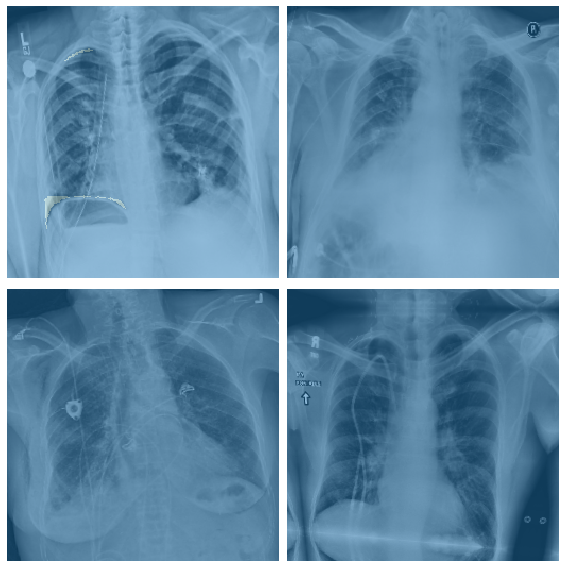

In [10]:
def get_data(fold):
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=SEED)
    valid_idx = list(kf.split(list(range(len(Path(TRAIN).ls())))))[fold][1]
    # Create databunch
    data = (SegmentationItemList.from_folder(TRAIN)
            .split_by_idx(valid_idx)
            .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0,1])
            .add_test(Path(TEST).ls(), label=None)
            .transform(get_transforms(), size=sz, tfm_y=True)
            .databunch(path=Path('.'), bs=bs)
            .normalize(stats))
    return data

# Display some images with masks
get_data(0).show_batch()

### Training

Expand the following cell to see the model printout. The model is based on Unet like architecture with ResNet34 based pretrained encoder. The upscaling is based on [pixel shuffling technique](https://arxiv.org/pdf/1609.05158.pdf). On the top, hypercolumns are added to provide additional skip-connections between the upscaling blocks and the output.

In [11]:
unet_learner(get_data(0), models.resnet34, metrics=[dice]).model

DynamicUnet_Hcolumns(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05,

In [12]:
scores, best_thrs = [],[]
for fold in range(nfolds):
    print('fold: ', fold)
    data = get_data(fold)
    learn = unet_learner(data, models.resnet34, metrics=[dice])
    learn.clip_grad(1.0);
    set_BN_momentum(learn.model)
    
    #fit the decoder part of the model keeping the encode frozen
    lr = 1e-3
    learn.fit_one_cycle(6, lr, callbacks = [AccumulateStep(learn,n_acc)])
    
    #fit entire model with saving on the best epoch
    learn.unfreeze()
    learn.fit_one_cycle(12, slice(lr/80, lr/2), callbacks=[AccumulateStep(learn,n_acc)])
    learn.save('fold'+str(fold));
    
    #prediction on val and test sets
    preds, ys = pred_with_flip(learn)
    pt, _ = pred_with_flip(learn,DatasetType.Test)
    
    if fold == 0: preds_test = pt
    else: preds_test += pt
        
    #convert predictions to byte type and save
    preds_save = (preds*255.0).byte()
    torch.save(preds_save, 'preds_fold'+str(fold)+'.pt')
    np.save('items_fold'+str(fold), data.valid_ds.items)
        
    #remove noise
    preds[preds.view(preds.shape[0],-1).sum(-1) < noise_th,...] = 0.0

    #optimal threshold 
    #The best way would be collecting all oof predictions followed by a single threshold
    #calculation. However, it requres too much RAM for high image resolution
    dices = []
    thrs = np.arange(0.01, 1, 0.01)
    for th in progress_bar(thrs):
        preds_m = (preds>th).long()
        dices.append(dice_overall(preds_m, ys).mean())
    dices = np.array(dices)    
    scores.append(dices.max())
    best_thrs.append(thrs[dices.argmax()])
     
    if fold != nfolds-1: del preds, ys, preds_save
    gc.collect()
    torch.cuda.empty_cache()
    
preds_test /= nfolds

RuntimeError: CUDA out of memory. Tried to allocate 2.61 GiB (GPU 0; 7.77 GiB total capacity; 3.74 GiB already allocated; 2.29 GiB free; 433.09 MiB cached)

In [ ]:
print('scores: ', scores)
print('mean score: ', np.array(scores).mean())
print('thresholds: ', best_thrs)
best_thr = np.array(best_thrs).mean()
print('best threshold: ', best_thr)

In [ ]:
best_dice = dices.max()
plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thrs[-1], ymin=dices.min(), ymax=dices.max())
plt.text(best_thrs[-1]+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

In [ ]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

### Submission

If any pixels are predicted for an empty mask, the corresponding image gets zero score during evaluation. While prediction of no pixels for an empty mask gives pirfect score. Because of this penalty it is resonable to set masks to zero if the number of predicted pixels is small. This trick was quite efective in [Airbus Ship Detection Challenge](https://www.kaggle.com/iafoss/unet34-submission-tta-0-699-new-public-lb).

In [ ]:
#convert predictions to byte type and save
preds_save = (preds_test*255.0).byte()
torch.save(preds_save, 'preds_test.pt')
# preds_test = torch.load('preds_fold0.pt')#/ 255
# preds_test = preds_test.type('torch.FloatTensor') / 255.0
# best_thr = 0.2
# data = get_data(0)

In [ ]:
preds_test[preds_test.view(preds_test.shape[0],-1).sum(-1) < noise_th,...] = 0.0

In [ ]:
# Generate rle encodings (images are first converted to the original size)
preds_test = (preds_test>best_thr).long().numpy()
rles = []
for p in progress_bar(preds_test):
    im = PIL.Image.fromarray((p.T*255).astype(np.uint8)).resize((1024,1024))
    im = np.asarray(im)
    rles.append(mask2rle(im, 1024, 1024))

In [ ]:
ids = [o.stem for o in data.test_ds.items]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.to_csv('submission.csv', index=False)
sub_df.head()